In [1]:
import sys

sys.path.append("../")

import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Importing from the module
from src.rf import evaluate_classifier, load_data

# Configuration for Random Forest
config_rf = {
    "test_file": "../models/rf/test/tfidf.parquet",
    "classifier_path": "../models/rf/runs/2024-04-06_22-20-09/classifier.joblib",
}

# Load the test data
x_test, y_test = load_data(config_rf["test_file"])

# Load the pretrained Random Forest model
clf = joblib.load(config_rf["classifier_path"])

# Evaluate the classifier
y_pred, y_pred_proba, metrics = evaluate_classifier(clf, x_test, y_test)

2024-04-07 14:27:23 [INFO] Loading data from ../models/rf/test/tfidf.parquet
2024-04-07 14:27:23 [INFO] Evaluating classifier
2024-04-07 14:27:24 [INFO] Accuracy: 0.997835
2024-04-07 14:27:24 [INFO] Precision: 0.991265
2024-04-07 14:27:24 [INFO] Recall: 0.991265
2024-04-07 14:27:24 [INFO] F1: 0.991265
2024-04-07 14:27:24 [INFO] ROC AUC: 0.998911


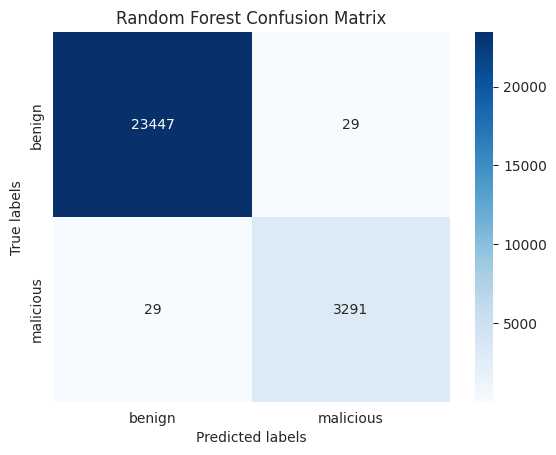

In [2]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g", cmap="Blues")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Random Forest Confusion Matrix")
ax.xaxis.set_ticklabels(["benign", "malicious"])
ax.yaxis.set_ticklabels(["benign", "malicious"])
plt.savefig("../.readme/rf_confusion_matrix.svg")
plt.show()

In [3]:
# Load the raw test data for printing failure cases
test_data = pd.read_parquet("../models/rf/test/processed.parquet")

# Print metrics
print("Accuracy: ", metrics["accuracy"])
print("Precision: ", metrics["precision"])
print("Recall: ", metrics["recall"])
print("F1: ", metrics["f1"])
print("ROC AUC: ", metrics["roc_auc"])

# Print failure cases
failures_rf = np.where(y_pred != y_test)[0]
for index in failures_rf:
    print(f"True label: {y_test.iloc[index]}, Predicted label: {y_pred[index]}")
    assert test_data.iloc[index]["label"] == y_test.iloc[index]
    print("Category: ", test_data.iloc[index]["category"])
    print("Payload: ", test_data.iloc[index]["payload"])
    print("-" * 100)

# Print counts of predicted malicious and benign samples
print("count_mailicious: ", np.sum(y_pred == "malicious"))
print("count_benign: ", np.sum(y_pred == "benign"))


Accuracy:  0.9978354978354979
Precision:  0.9912650602409638
Recall:  0.9912650602409638
F1:  0.9912650602409638
ROC AUC:  0.9989107563325376
True label: malicious, Predicted label: benign
Category:  xss
Payload:  iframe.contentwindow.location.constructor.prototype
----------------------------------------------------------------------------------------------------
True label: malicious, Predicted label: benign
Category:  xss
Payload:  javascript:document.location='http://www.google.com/
----------------------------------------------------------------------------------------------------
True label: benign, Predicted label: malicious
Category:  xss
Payload:   </div
----------------------------------------------------------------------------------------------------
True label: malicious, Predicted label: benign
Category:  xss
Payload:  width:\0065\0078\0070\0072\0065\0073\0073\0069\006f\006e\0028\0070\0072\006f\006d\0070\0074\0028\0031\0029\0029
-------------------------------------------

In [4]:
len(y_pred)

26796

In [5]:
len(failures_rf)

58

In [6]:
count_mailicious_total = 0
count_mailicious_failures = 0

count_benign_total = 0
count_benign_failures = 0

for i in range(len(y_pred)):
    if y_pred[i] == "malicious":
        count_mailicious_total += 1
        if y_pred[i] != y_test[i]:
            count_mailicious_failures += 1
    else:
        count_benign_total += 1
        if y_pred[i] != y_test[i]:
            count_benign_failures += 1

print("Mailicious Total: ", count_mailicious_total)
print("Mailicious Failures: ", count_mailicious_failures)
print("Mailicious Failure Rate: ", count_mailicious_failures / count_mailicious_total)

print("-" * 100)

print("Benign Total: ", count_benign_total)
print("Benign Failures: ", count_benign_failures)
print("Benign Failure Rate: ", count_benign_failures / count_benign_total)

Mailicious Total:  3320
Mailicious Failures:  29
Mailicious Failure Rate:  0.008734939759036145
----------------------------------------------------------------------------------------------------
Benign Total:  23476
Benign Failures:  29
Benign Failure Rate:  0.001235304140398705


In [7]:
num_samples = 1000
clf.verbose = 0
start = time.time()
for i in tqdm(range(num_samples)):
    clf.predict(x_test[i : i + 1])

end = time.time()
print(f"Avg. CPU inference time: {(end - start) * 1000 / num_samples:.2f} ms")


  0%|          | 5/1000 [00:00<00:23, 42.50it/s]

100%|██████████| 1000/1000 [00:24<00:00, 40.10it/s]

Avg. CPU inference time: 24.94 ms
